In [1]:
# Erasmus+ ICCT project (2018-1-SI01-KA203-047081)

# Toggle cell visibility

from IPython.display import HTML
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.input').hide()
    } else {
        $('div.input').show()
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Toggle cell visibility <a href="javascript:code_toggle()">here</a>.''')
display(tag)

# Hide the code completely

# from IPython.display import HTML
# tag = HTML('''<style>
# div.input {
#     display:none;
# }
# </style>''')
# display(tag)

In [2]:
# Erasmus+ ICCT project (2018-1-SI01-KA203-047081)

%matplotlib notebook
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import signal
import ipywidgets as widgets

## Posizionamento poli/zeri

La mappa poli-zeri è una rappresentazione grafica degli zeri e dei poli della funzione di trasferimento di un sistema. La disposizione degli zeri e soprattutto dei poli ci fornisce molte informazioni sulle proprietà del sistema. La stabilità, ad esempio, è assicurata se tutti i poli si trovano nella metà sinistra aperta del piano complesso.

---

### Come usare questo notebook?

Per spostare un polo (contrassegnato da una croce verde) o uno zero (coppia di zeri) (contrassegnato da un cerchio verde) è sufficiente cliccare e trascinare. Per aggiungere o rimuovere un polo o uno zero (coppia di zeri) cliccare il pulsante corrispondente.

<IPython.core.display.Javascript object>


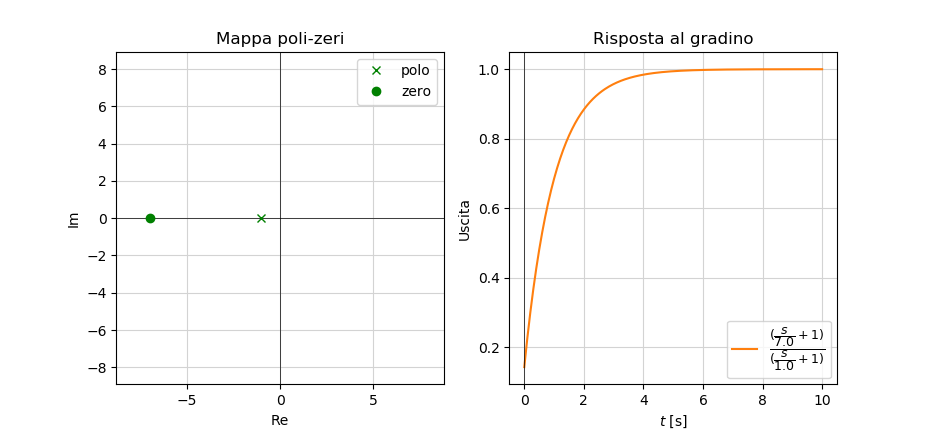

In [3]:
x_axis = [[-10, 10], [0, 0]] #lists of ploted axes [[x-data], [y-data]]
y_axis = [[0, 0], [-10, 10]]

poles = [] # list of coordinates of poles
zeros = [] # list of coordinates of zeros
doublepoles = []
doublezeros = []

def calc_gain(poles, doublepoles, zeros, doublezeros):
    # calculate gain of the system (to be final value equal one)
    gain = 1
    for pole in poles:
        if pole[0] !=0:
            gain *= np.abs(pole[0])
    for zero in zeros:
        if zero[0] !=0:
            gain /= (-1)*zero[0]#np.abs(zero[0])
    for doublepole in doublepoles:
        gain *= np.abs(np.sqrt((doublepole[0])**2+(doublepole[1])**2))
    for doublezero in doublezeros:
        gain /= np.abs(np.sqrt((doublezero[0])**2+(doublezero[1])**2))
    return gain

def make_label(poles, doublepoles, zeros, doublezeros):
    den_str = ''
    number_integrators = 0
    for i in poles:
        if i[0] == 0:
            number_integrators += 1
    if number_integrators == 1:
        den_str = ''.join((den_str, 's'))
    elif number_integrators >1:
        den_str = ''.join((den_str, 's^{', '{:1d}'.format(number_integrators), '}'))
    for i in poles:
        sign = '+' if i[0]<0 else '-'
        #den_str = ''.join((den_str, '(s', sign, '{:.1f}'.format(np.abs(i[0])), ')'))
        if np.abs(i[0]) != 0:
            den_str = ''.join((den_str, '(\dfrac{s}','{', '{:.1f}'.format(np.abs(i[0])), '}', sign, '1', ')'))
    for number in range(len(doublepoles)):
        if number % 2 == 1:
            continue
        else:
            i = doublepoles[number]
            if i[0] != 0:
                sign = '+' if i[0]<0 else '-'
                #den_str = ''.join((den_str, '(s^{2}', sign, '{:.1f}'.format(np.abs(2*i[0])), ' s', '+{:.1f}'.format(i[0]**2+i[1]**2), ')'))
                den_str = ''.join((den_str, '(\dfrac{s^{2}}{', '{:.1f}'.format(i[0]**2+i[1]**2), '}', sign, '\dfrac{s}{', '{:.1f}'.format((i[0]**2+i[1]**2)/np.abs(2*i[0])), '}+1', ')'))
            else:
                den_str = ''.join((den_str, '(\dfrac{s^{2}}{', '{:.1f}'.format(i[0]**2+i[1]**2), '}+1', ')'))

    num_str = ''
    if len(zeros+doublezeros) >0:
        number_integrators = 0
        for i in zeros:
            if i[0] == 0:
                number_integrators += 1
        if number_integrators == 1:
            num_str = ''.join((num_str, 's'))
        elif number_integrators >1:
            num_str = ''.join((num_str, 's^{', '{:1d}'.format(number_integrators), '}'))
        for i in zeros:
            sign = '+' if i[0]<0 else '-'
            #num_str = ''.join((num_str, '(s', sign, '{:.1f}'.format(np.abs(i[0])), ')'))
            if np.abs(i[0]) != 0:
                num_str = ''.join((num_str, '(\dfrac{s}','{', '{:.1f}'.format(np.abs(i[0])), '}', sign, '1', ')'))
        for number in range(len(doublezeros)):
            if number % 2 == 1:
                continue
            else:
                i = doublezeros[number]
            if i[0] != 0:
                sign = '+' if i[0]<0 else '-'
                #num_str = ''.join((num_str, '(s^{2}', sign, '{:.1f}'.format(np.abs(2*i[0])), ' s', '+{:.1f}'.format(i[0]**2+i[1]**2), ')'))
                num_str = ''.join((num_str, '(\dfrac{s^{2}}{', '{:.1f}'.format(i[0]**2+i[1]**2), '}', sign, '\dfrac{s}{', '{:.1f}'.format((i[0]**2+i[1]**2)/np.abs(2*i[0])), '}+1', ')'))
            else:
                num_str = ''.join((num_str, '(\dfrac{s^{2}}{', '{:.1f}'.format(i[0]**2+i[1]**2), '}+1', ')'))
    else:
        num_str = '1'
        
    #label = ''.join(('${:.1f}'.format(calc_gain(poles, doublepoles, zeros, doublezeros)), '\,\dfrac{',num_str, '}{', den_str, '}$'))
    sign = ''if calc_gain(poles, doublepoles, zeros, doublezeros)>=0 else '-'
    label = ''.join(('$', sign, '\,\dfrac{',num_str, '}{', den_str, '}$'))
   
    return label

drag = False # variable for mouse drag, which on a list is dragged
dragged = False # flag which is dragged (pole or zero)

fig = plt.figure(figsize=(9.8, 4),num='Piazzamento poli-zeri') # figure, where to plot



root = fig.add_subplot(121) #axes for root locus plot
root.set_xlabel('Re')
root.set_ylabel('Im')
root.set_title('Mappa poli-zeri')
root.set_xlim([-10,10])
root.set_ylim([-10,10])
root.axhline(linewidth=.5, color='k')
root.axvline(linewidth=.5, color='k')
root.set_aspect('equal', adjustable='datalim')
root.grid(which='both', axis='both', color='lightgray')

step_plot = fig.add_subplot(122) # axes for step plot
step_plot.set_xlabel('$t$ [s]')
step_plot.set_ylabel('Uscita')
step_plot.set_title('Risposta al gradino')
root.set_aspect('equal', adjustable='datalim')
step_plot.grid(which='both', axis='both', color='lightgray')

# points, which appear at start of program
poles.append([-1, 0])
zeros.append([-7, 0])

# computing init step response data
sig = signal.ZerosPolesGain([zeros[0][0]], [poles[0][0]], calc_gain(poles, doublepoles, zeros, doublezeros)) # Close loop transfer function (ZerosPolesGain)
timep, stepr = signal.step(sig, T=np.linspace(0,10,300))

# plotting init plot
poles_plot, = root.plot(poles[0][0], poles[0][1], 'xg', label='polo')
zeros_plot, = root.plot(zeros[0][0], zeros[0][1], 'og', label='zero')
doublepoles_plot, = root.plot([], [], 'xg', lw=2)
doublezeros_plot, = root.plot([], [], 'og', lw=2)
#for plotting colored , which are dragged
dragged_plot_poles, = root.plot([],[],'bx')
dragged_plot_zeros, = root.plot([],[],'bo')

step_ax, = step_plot.plot(timep, stepr, 'C1', lw=1.5, label=make_label(poles, doublepoles, zeros, doublezeros))
step_plot.set_ylim([min(stepr)-max(stepr)*.05,max(stepr)*1.05])
step_plot.legend(loc=4, prop={'size': 10-max(len(poles+doublepoles),len(zeros+doublezeros))})
step_plot.axhline(linewidth=.5, color='k')
step_plot.axvline(linewidth=.5, color='k')
root.legend()
plt.show()  

# FIRST PART, for manipulating zeros and poles on matplotlib plot
def check_point_clicked(xdata, ydata):
    global poles, zeros, poles_plot, zeros_plot, dragged, drag
    global doublepoles, doublezeros, doublezeros_plot, doublepoles_plot
    tolerance = .3
    for i in range(len(poles)):
        pole = poles[i]
        if ((xdata-pole[0])**2 + (ydata-pole[1])**2)**0.5 < tolerance: # check if pole near (xdata, ydata)
            drag = i
            dragged_plot_poles.set_data([poles[drag][0]],[poles[drag][1]])
            dragged_plot_poles.set_marker('x')
            dragged_plot_poles.set_visible(True)
            dragged = 'pole'
            return
    for i in range(len(zeros)):
        zero = zeros[i]
        if ((xdata-zero[0])**2 + (ydata-zero[1])**2)**0.5 < tolerance:
            drag = i
            dragged_plot_zeros.set_data([zeros[drag][0]],[zeros[drag][1]])
            dragged_plot_zeros.set_visible(True)
            dragged = 'zero'
            return
    #check also in doublepoles/doublezeros lists
    for i in range(len(doublepoles)):
        doublepole = doublepoles[i]
        if ((xdata-doublepole[0])**2 + (ydata-doublepole[1])**2)**0.5 < tolerance: # check if doublepole near (xdata, ydata)
            dragged = 'doublepole'
            drag = i
            if i%2 == 0:
                dragged_plot_poles.set_data([doublepoles[drag][0],doublepoles[drag+1][0]],[doublepoles[drag][1],doublepoles[drag+1][1]])
            if i%2 == 1:
                dragged_plot_poles.set_data([doublepoles[drag-1][0],doublepoles[drag][0]],[doublepoles[drag-1][1],doublepoles[drag][1]])
            dragged_plot_poles.set_visible(True)
            return
    for i in range(len(doublezeros)):
        doublezero = doublezeros[i]
        if ((xdata-doublezero[0])**2 + (ydata-doublezero[1])**2)**0.5 < tolerance:
            dragged = 'doublezero'
            drag = i
            if i%2 == 0:
                dragged_plot_zeros.set_data([doublezeros[drag][0],doublezeros[drag+1][0]],[doublezeros[drag][1],doublezeros[drag+1][1]])
            if i%2 == 1:
                dragged_plot_zeros.set_data([doublezeros[drag-1][0],doublezeros[drag][0]],[doublezeros[drag-1][1],doublezeros[drag][1]])
            dragged_plot_zeros.set_visible(True)
            return

# when click on left mouse button
def onclick(event):
    mouse_coordx = np.round(event.xdata, 1)
    mouse_coordy = np.round(event.ydata, 1)#extract location of mouse cursor
    check_point_clicked(mouse_coordx, mouse_coordy) # which point is dragged

def onrelease(event):
    global poles_plot, zeros_plot, dragged, drag, poles, zeros
    global doublepoles_plot, doublezeros_plot, doublepoles, doublezeros
    mouse_coordx = np.round(event.xdata, 1)
    mouse_coordy = np.round(event.ydata, 1)
    if dragged == 'pole':
        poles[drag][0] = mouse_coordx
        poles_plot.set_data([poles[i][0] for i in range(len(poles))], [poles[j][1] for j in range(len(poles))])
        dragged_plot_poles.set_visible(False)
    if dragged == 'zero':
        zeros[drag][0] = mouse_coordx
        zeros_plot.set_data([zeros[i][0] for i in range(len(zeros))], [zeros[j][1] for j in range(len(zeros))])
        dragged_plot_zeros.set_visible(False)
    if dragged == 'doublepole':
        doublepoles[drag] = [mouse_coordx, mouse_coordy]
        if drag%2 == 0:
            doublepoles[drag+1] = [mouse_coordx, -mouse_coordy]
        else:
            doublepoles[drag-1] = [mouse_coordx, -mouse_coordy]
        doublepoles_plot.set_data([doublepoles[i][0] for i in range(len(doublepoles))],
                                  [doublepoles[j][1] for j in range(len(doublepoles))])
        dragged_plot_poles.set_visible(False)
    if dragged == 'doublezero':
        doublezeros[drag] = [mouse_coordx, mouse_coordy]
        if drag%2 == 0:
            doublezeros[drag+1] = [mouse_coordx, -mouse_coordy]
        else:
            doublezeros[drag-1] = [mouse_coordx, -mouse_coordy]
        doublezeros_plot.set_data([doublezeros[i][0] for i in range(len(doublezeros))],
                                  [doublezeros[j][1] for j in range(len(doublezeros))])
        dragged_plot_zeros.set_visible(False)

    
    sig = signal.ZerosPolesGain([zero[0]+zero[1]*1j for zero in zeros + doublezeros], # zeros
                                [pole[0]+pole[1]*1j for pole in poles + doublepoles], # poles
                                calc_gain(poles, doublepoles, zeros, doublezeros))  # gain
    timep, stepr = signal.step(sig, T=np.linspace(0,10,300))

    #update step plots
    step_ax.set_data(timep, stepr)
    step_plot.set_ylim([min(stepr)-max(stepr)*.05,max(stepr)*1.05])
    step_ax.set_label(make_label(poles, doublepoles, zeros, doublezeros))
    step_plot.legend(loc=4, prop={'size': 10-.5*max(len(poles+doublepoles),len(zeros+doublezeros))})
    drag = False
    dragged = False

t = 0 # variable for plotting motion faster
fastRat = 7 # how much times faster
def onmotion(event):
    global t, poles_plot, zeros_plot, dragged, poles, zeros, drag
    global doublepoles, doublezeros, doublepoles_plot, doublezeros_plot
    if dragged:
        mouse_coordx = np.round(event.xdata, 1)
        mouse_coordy = np.round(event.ydata, 1)
        if t%fastRat == fastRat-1:# for faster plotting in jupyter notebook
            if dragged == 'pole':
                poles[drag][0] = mouse_coordx
                poles_plot.set_data([poles[i][0] for i in range(len(poles))], [poles[j][1] for j in range(len(poles))])
                dragged_plot_poles.set_data([poles[drag][0]],[poles[drag][1]])
            if dragged == 'zero':
                zeros[drag][0] = mouse_coordx
                zeros_plot.set_data([zeros[i][0] for i in range(len(zeros))], [zeros[j][1] for j in range(len(zeros))])
                dragged_plot_zeros.set_data([zeros[drag][0]],[zeros[drag][1]])
            if dragged == 'doublepole':
                doublepoles[drag] = [mouse_coordx, mouse_coordy]
                if drag%2 == 0:
                    doublepoles[drag+1] = [mouse_coordx, -mouse_coordy]
                elif drag%2 == 1:
                    doublepoles[drag-1] = [mouse_coordx, -mouse_coordy]
                else:
                    raise Exception
                doublepoles_plot.set_data([doublepoles[i][0] for i in range(len(doublepoles))],
                                          [doublepoles[j][1] for j in range(len(doublepoles))])
                if drag%2 == 0:
                    dragged_plot_poles.set_data([doublepoles[drag][0],doublepoles[drag+1][0]],[doublepoles[drag][1],doublepoles[drag+1][1]])
                elif drag%2 == 1:
                    dragged_plot_poles.set_data([doublepoles[drag-1][0],doublepoles[drag][0]],[doublepoles[drag-1][1],doublepoles[drag][1]])
            if dragged == 'doublezero':
                doublezeros[drag] = [mouse_coordx, mouse_coordy]
                if drag%2 == 0:
                    doublezeros[drag+1] = [mouse_coordx, -mouse_coordy]
                elif drag%2 == 1:
                    doublezeros[drag-1] = [mouse_coordx, -mouse_coordy]
                doublezeros_plot.set_data([doublezeros[i][0] for i in range(len(doublezeros))],
                                          [doublezeros[j][1] for j in range(len(doublezeros))])
                if drag%2 == 0:
                    dragged_plot_zeros.set_data([doublezeros[drag][0],doublezeros[drag+1][0]],[doublezeros[drag][1],doublezeros[drag+1][1]])
                elif drag%2 == 1:
                    dragged_plot_zeros.set_data([doublezeros[drag-1][0],doublezeros[drag][0]],[doublezeros[drag-1][1],doublezeros[drag][1]])

    t = t + 1
    # for t not to become too large
    if t >= 1000*fastRat:
        t = 0

# mouse events for interactive plot
press_event = fig.canvas.mpl_connect('button_press_event', onclick)
motion_event = fig.canvas.mpl_connect('motion_notify_event', onmotion)
release_event = fig.canvas.mpl_connect('button_release_event', onrelease)

# SECOND PART, for adding and taking poles and zeros:

def check_improper_function():
    if len(poles+doublepoles) >= len(zeros+doublezeros)+2:
        TsinglePole.disabled=False
        TdoublePole.disabled=False
        AsingleZero.disabled=False
        AdoubleZero.disabled=False
    if len(poles+doublepoles) == len(zeros+doublezeros)+1:
        TsinglePole.disabled=False
        TdoublePole.disabled=True
        AsingleZero.disabled=False
        AdoubleZero.disabled=True
    if len(poles+doublepoles) == len(zeros+doublezeros):
        TsinglePole.disabled=True
        TdoublePole.disabled=True
        AsingleZero.disabled=True
        AdoubleZero.disabled=True
    if len(poles+doublepoles) < len(zeros+doublezeros):
        raise Exception('Errore nel sistema, funzione di trasferimento impropria')
    if len(poles)<=1 and len(doublepoles)==0 or len(poles)==0 and len(doublepoles)<=2:
        TsinglePole.disabled=True
        TdoublePole.disabled=True
    
def update_plot():
    sig = signal.ZerosPolesGain([zero[0]+zero[1]*1j for zero in zeros + doublezeros], # zeros
                                [pole[0]+pole[1]*1j for pole in poles + doublepoles], # poles
                                calc_gain(poles, doublepoles, zeros, doublezeros))  # gain
    timep, stepr = signal.step(sig, T=np.linspace(0,10,300))
    #update step plots
    step_ax.set_data(timep, stepr)
    step_plot.set_ylim([min(stepr)-max(stepr)*.05,max(stepr)*1.05])
    step_ax.set_label(make_label(poles, doublepoles, zeros, doublezeros))
    step_plot.legend(loc=4, prop={'size': 10-.5*max(len(poles+doublepoles),len(zeros+doublezeros))})
    
    
# functions for event buttons 
def AsinglePole_clicked(event):
    if len(poles) <= 10:
        poles.append([0, 0])
        poles_plot.set_data([poles[i][0] for i in range(len(poles))], [poles[j][1] for j in range(len(poles))])
        check_improper_function()
        update_plot()
def TsinglePole_clicked(event):
    if len(poles) >= 1:
        poles.pop(-1)
        poles_plot.set_data([poles[i][0] for i in range(len(poles))], [poles[j][1] for j in range(len(poles))])
        check_improper_function()
        update_plot()

def AdoublePole_clicked(event):
    if len(doublepoles) <= 10:
        doublepoles.append([0, 1])
        doublepoles.append([0, -1])
        doublepoles_plot.set_data([doublepoles[i][0] for i in range(len(doublepoles))],
                                  [doublepoles[j][1] for j in range(len(doublepoles))])
        check_improper_function()
        update_plot()
def TdoublePole_clicked(event):
    if len(doublepoles) >= 2:
        doublepoles.pop(-1)
        doublepoles.pop(-1)
        doublepoles_plot.set_data([doublepoles[i][0] for i in range(len(doublepoles))],
                                    [doublepoles[j][1] for j in range(len(doublepoles))])
        check_improper_function()
        update_plot()

def AsingleZero_clicked(event):
    if len(zeros) <= 10:
        zeros.append([0, 0])
        zeros_plot.set_data([zeros[i][0] for i in range(len(zeros))], [zeros[j][1] for j in range(len(zeros))])
        check_improper_function()
        update_plot()
def TsingleZero_clicked(event):
    if len(zeros) >= 1:
        zeros.pop(-1)
        zeros_plot.set_data([zeros[i][0] for i in range(len(zeros))], [zeros[j][1] for j in range(len(zeros))])
        check_improper_function()
        update_plot()
    
def AdoubleZero_clicked(event):
    if len(doublezeros) <= 10:
        doublezeros.append([0, 1])
        doublezeros.append([0, -1])
        doublezeros_plot.set_data([doublezeros[i][0] for i in range(len(doublezeros))],
                                  [doublezeros[j][1] for j in range(len(doublezeros))])
        check_improper_function()
        update_plot()
def TdoubleZero_clicked(event):
    if len(doublezeros)>=2:
        doublezeros.pop(-1)
        doublezeros.pop(-1)
        doublezeros_plot.set_data([doublezeros[i][0] for i in range(len(doublezeros))],
                                  [doublezeros[j][1] for j in range(len(doublezeros))])
        check_improper_function()
        update_plot()

# defined buttons for adding or taking poles and zeros

AsinglePole = widgets.Button(description='Aggiungi polo', disabled=False, tooltip='Cliccami', icon='', layout=widgets.Layout(width='180px', height='40px'))
AdoublePole = widgets.Button(description='Aggiungi coppia di poli complessi', disabled=False, tooltip='Click me', icon='', layout=widgets.Layout(width='250px', height='40px'))

AsingleZero = widgets.Button(description='Aggiungi zero', disabled=False, tooltip='Cliccami', icon='', layout=widgets.Layout(width='180px', height='40px'))
AdoubleZero = widgets.Button(description='Aggiungi coppia di zeri complessi', disabled=False, tooltip='Click me', icon='', layout=widgets.Layout(width='250px', height='40px'))

TsinglePole = widgets.Button(description='Rimuovi polo', disabled=False, tooltip='Cliccami', icon='', layout=widgets.Layout(width='180px', height='40px'))
TdoublePole = widgets.Button(description='Rimuovi coppia di poli complessi', disabled=False, tooltip='Click me', icon='', layout=widgets.Layout(width='250px', height='40px'))

TsingleZero = widgets.Button(description='Rimuovi zero', disabled=False, tooltip='Cliccami', icon='', layout=widgets.Layout(width='180px', height='40px'))
TdoubleZero = widgets.Button(description='Rimuovi coppia di zeri complessi', disabled=False, tooltip='Click me', icon='', layout=widgets.Layout(width='250px', height='40px'))

# make layout
column1 = widgets.VBox([AsinglePole, TsinglePole])
column2 = widgets.VBox([AdoublePole, TdoublePole])
column3 = widgets.VBox([AsingleZero, TsingleZero])
column4 = widgets.VBox([AdoubleZero, TdoubleZero])

both_columns = widgets.HBox([column1, column2, column3, column4])

display(both_columns)

# defined events
AsinglePole.on_click(AsinglePole_clicked)
AdoublePole.on_click(AdoublePole_clicked)
AsingleZero.on_click(AsingleZero_clicked)
AdoubleZero.on_click(AdoubleZero_clicked)

TsinglePole.on_click(TsinglePole_clicked)
TdoublePole.on_click(TdoublePole_clicked)
TsingleZero.on_click(TsingleZero_clicked)
TdoubleZero.on_click(TdoubleZero_clicked)

check_improper_function()